In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [53]:
# Set 1 qubit and default simulator
n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits)

Step   0: Loss=0.476641, Max θ change=0.015830
Step  10: Loss=0.416756, Max θ change=0.013620
Step  20: Loss=0.345859, Max θ change=0.012683
Step  30: Loss=0.264043, Max θ change=0.012935
Step  40: Loss=0.191287, Max θ change=0.012914
Step  50: Loss=0.132734, Max θ change=0.012026
Step  60: Loss=0.087558, Max θ change=0.010549
Step  70: Loss=0.055337, Max θ change=0.008644
Step  80: Loss=0.034569, Max θ change=0.006608
Step  90: Loss=0.022124, Max θ change=0.004774
Step 100: Loss=0.014866, Max θ change=0.003955
Step 110: Loss=0.010581, Max θ change=0.003332
Step 120: Loss=0.007949, Max θ change=0.002835
Step 130: Loss=0.006237, Max θ change=0.002439
Step 140: Loss=0.005059, Max θ change=0.002122
Step 150: Loss=0.004204, Max θ change=0.001866
Step 160: Loss=0.003557, Max θ change=0.001656
Step 170: Loss=0.003053, Max θ change=0.001482
Step 180: Loss=0.002650, Max θ change=0.001335
Step 190: Loss=0.002322, Max θ change=0.001212


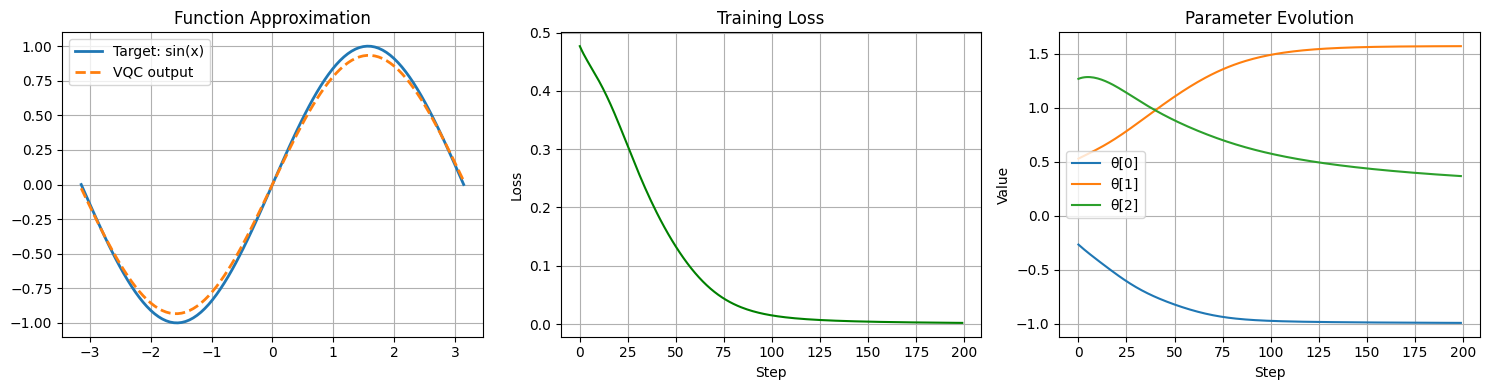

In [57]:
# Simple working quantum circuit
from math import pi
@qml.qnode(dev, interface='autograd')
def simple_working_circuit(x, theta):
    qml.RY(theta[0] * x + theta[1], wires=0)
    qml.RX(theta[2], wires=0)
    return qml.expval(qml.PauliZ(0))

# Loss function
def loss_function(theta, x_data, y_target):
    predictions = np.array([simple_working_circuit(xi, theta) for xi in x_data])
    return np.mean((predictions - y_target) ** 2)

# Training data
x_data = np.linspace(-pi, pi, 100)
y_target = np.sin(x_data)

# Initialize parameters
theta = np.random.uniform([-0.5, 0.5, 3], requires_grad=True)

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.05)

# Training loop
n_steps = 200
losses = []
param_history = []

for step in range(n_steps):
    param_history.append(theta.copy())
    current_loss = loss_function(theta, x_data, y_target)
    losses.append(current_loss)

    theta_old = theta.copy()
    theta, _ = opt.step_and_cost(
        lambda params: loss_function(params, x_data, y_target), theta
    )

    if step % 10 == 0:
        change = np.max(np.abs(theta - theta_old))
        print(f"Step {step:3d}: Loss={current_loss:.6f}, Max θ change={change:.6f}")

# Final prediction
y_pred = [simple_working_circuit(xi, theta) for xi in x_data]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Function approximation
axes[0].plot(x_data, y_target, label='Target: sin(x)', linewidth=2)
axes[0].plot(x_data, y_pred, '--', label='VQC output', linewidth=2)
axes[0].set_title("Function Approximation")
axes[0].legend()
axes[0].grid(True)

# 2. Loss curve
axes[1].plot(losses, 'g-', label='Loss')
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Loss")
axes[1].grid(True)

# 3. Parameter evolution
param_history = np.array(param_history)
for i in range(param_history.shape[1]):
    axes[2].plot(param_history[:, i], label=f"θ[{i}]")
axes[2].set_title("Parameter Evolution")
axes[2].set_xlabel("Step")
axes[2].set_ylabel("Value")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

Step   0 | Loss: 0.495161
Step  20 | Loss: 0.214869
Step  40 | Loss: 0.160285
Step  60 | Loss: 0.150391
Step  80 | Loss: 0.140662
Step 100 | Loss: 0.131390
Step 120 | Loss: 0.122876
Step 140 | Loss: 0.115163
Step 160 | Loss: 0.108166
Step 180 | Loss: 0.101758


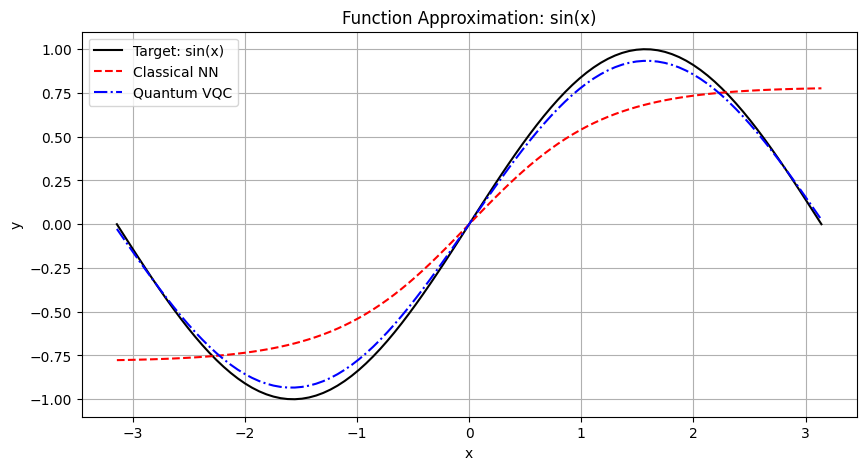

In [58]:
# In contrast, a non-quantum method : a 1 hidden-layer neural network
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt

x_data = np.linspace(-np.pi, np.pi, 100)
y_target = np.sin(x_data)

np.random.seed(42)
n_hidden = 5 # Number of hidden neurons
params = {
    'W1': np.random.randn(n_hidden) * 0.1,
    'b1': np.zeros(n_hidden),
    'W2': np.random.randn(n_hidden) * 0.1,
    'b2': np.array(0.0)
}

# Activation function 
def tanh(x): 
    return np.tanh(x)

# Forward pass for the neural network
def forward(x, params):
    h = tanh(params['W1'] * x[:, None] + params['b1'])  # shape: [batch, hidden]
    out = np.dot(h, params['W2']) + params['b2']
    return out

# MSE loss function
def loss_fn(params, x, y):
    y_pred = forward(x, params)
    return np.mean((y - y_pred)**2)

# Get gradient function
grad_fn = grad(loss_fn)

# optimize parameters
lr = 0.05
n_steps = 200
losses = []

for step in range(n_steps):
    grads = grad_fn(params, x_data, y_target)

    # gradient descent update
    for key in params:
        params[key] -= lr * grads[key]
    
    # record loss
    current_loss = loss_fn(params, x_data, y_target)
    losses.append(current_loss)
    
    if step % 20 == 0:
        print(f"Step {step:3d} | Loss: {current_loss:.6f}")

# Final prediction
y_pred = forward(x_data, params)

plt.figure(figsize=(10, 5))

# Original target function
plt.plot(x_data, y_target, 'k-', label='Target: sin(x)')

# prediction by NN
plt.plot(x_data, y_pred, 'r--', label='Classical NN')

# Prediction by Quantum VQC
y_pred_quantum = [simple_working_circuit(xi, theta) for xi in x_data]
plt.plot(x_data, y_pred_quantum, 'b-.', label='Quantum VQC')

plt.title("Function Approximation: sin(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()